In [1]:
import numpy as np
import scanpy as sc
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score, jaccard_score
import seaborn as sns

## Casual Graphs

In [ ]:
def preprocess_data(X, Y):
    """
    Preprocesamiento específico para scRNA-seq
    """
    print("🔬 Preprocesando datos scRNA-seq...")
    
    # 1. Filtrar genes con muy poca expresión
    # Suma la expresión de cada gen across todas las células 
    # Elimina genes en el percentil 10 más bajo (genes "silenciosos")
    gene_expression_sum = np.sum(X, axis=0)
    active_genes = gene_expression_sum > np.percentile(gene_expression_sum, 10)
    X_filtered = X[:, active_genes]
    
    # 2. Normalización log1p (típica en scRNA-seq)
    X_log = np.log1p(X_filtered)
    
    # 3. Separar casos y controles para análisis diferencial
    case_mask = Y == 1
    control_mask = Y == 0
    
    X_cases = X_log[case_mask]
    X_controls = X_log[control_mask]
    
    print(f"   📊 Genes activos: {np.sum(active_genes)}/{len(active_genes)}")
    print(f"   📊 Enfermos: {np.sum(case_mask)}, Controles: {np.sum(control_mask)}")
    
    return X_log, X_cases, X_controls, active_genes

def compute_differential_features(X_cases, X_controls):
    """
    Identificar genes diferencialmente expresados
    """
    print("🔍 Calculando expresión diferencial...")
    
    # Calcular medias por grupo
    mean_cases = np.mean(X_cases, axis=0)
    mean_controls = np.mean(X_controls, axis=0)
    
    # Fold change y significancia estadística simple
    fold_change = mean_cases - mean_controls
    
    # Seleccionar genes con mayor variabilidad diferencial
    abs_fold_change = np.abs(fold_change)
    diff_threshold = np.percentile(abs_fold_change, 75)
    differential_genes = abs_fold_change > diff_threshold
    
    print(f"   📈 Genes diferenciales: {np.sum(differential_genes)}")
    return differential_genes, fold_change

def infer_causal_graph(expression_df, top_genes=500, top_edges=200):
    """
    Infer a causal-like graph by selecting the top-N strongest absolute correlations.
    - expression_df : pd.DataFrame (cells × genes)
    - top_genes     : number of most variable genes to keep
    - top_edges     : number of strongest correlations to convert into edges
    """
    print("🔗 Inferring Causal Graph (top-N strongest correlations)…")

    causal_graph = nx.DiGraph()
    results = {'clusters': None, 'causal_edges': [], 'kg_enrichment': {},
               'llm_interpretations': []}

    # 1. choose top variable genes
    gene_vars = expression_df.var()
    top_gene_names = gene_vars.nlargest(min(top_genes, expression_df.shape[1])).index
    subset        = expression_df[top_gene_names]

    # 2. compute correlation matrix
    corr = subset.corr()

    # 3. flatten upper triangle into a ranked edge list
    corr_vals = (
        corr.where(~np.eye(len(corr), dtype=bool))  # drop diagonal
            .unstack()
            .dropna()
            .abs()
            .sort_values(ascending=False)
    )

    # 4. take top-N strongest correlations
    selected = corr_vals.head(top_edges)

    # 5. add as directed edges (heuristic: higher-variance gene → lower-variance)
    var_series = gene_vars[top_gene_names]
    for (g1, g2), val in selected.items():
        if var_series[g1] >= var_series[g2]:
            causal_graph.add_edge(g1, g2, weight=val, evidence='top_corr')
            results['causal_edges'].append((g1, g2, val))
        else:
            causal_graph.add_edge(g2, g1, weight=val, evidence='top_corr')
            results['causal_edges'].append((g2, g1, val))

    print(f"  ✅ Causal Graph inferred: {causal_graph.number_of_edges()} edges")
    return causal_graph, results

def discover_mechanisms(causal_graph, fold_change, n_mechanisms=5):
    """
    Agrupa genes en módulos mecanísticos a partir del grafo causal.
    
    Args:
        causal_graph: NetworkX DiGraph
        fold_change: array con fold changes de genes
        n_mechanisms: número de mecanismos a descubrir
    
    Returns:
        dict: discovered_mechanisms con estructura {mech_id: {vars, effects, type}}
    """
    
    if len(causal_graph.nodes()) == 0:
        print("⚠️ Grafo vacío, retornando mecanismos vacíos")
        return {}
    
    # Convertir grafo a matriz de adyacencia
    genes = list(causal_graph.nodes())
    adj_matrix = nx.to_numpy_array(causal_graph)
    
    # Si hay muy pocos nodos, ajustar n_mechanisms
    n_mechanisms = min(n_mechanisms, len(genes))
    
    if n_mechanisms <= 1:
        # Caso simple: un solo mecanismo con todos los genes
        discovered = {
            "mech_0": {
                "vars": genes,
                "effects": [1] * len(genes),  # por defecto positivo
                "type": "disease"
            }
        }
    else:
        # Clustering espectral para descubrir módulos
        clustering = SpectralClustering(n_clusters=n_mechanisms, 
                                      affinity='precomputed', 
                                      random_state=42)
        labels = clustering.fit_predict(adj_matrix + adj_matrix.T)  # simetrizar
        
        # Construir mecanismos por cluster
        discovered = {}
        for k in range(n_mechanisms):
            cluster_mask = labels == k
            cluster_genes = [genes[i] for i in range(len(genes)) if cluster_mask[i]]
            
            if len(cluster_genes) > 0:
                # Efectos basados en fold_change si está disponible
                if len(fold_change) >= len(genes):
                    effects = [np.sign(fold_change[i]) if fold_change[i] != 0 else 1 
                              for i in range(len(genes)) if cluster_mask[i]]
                else:
                    effects = [1] * len(cluster_genes)  # por defecto positivo
                
                discovered[f"mech_{k}"] = {
                    "vars": cluster_genes,
                    "effects": effects,
                    "type": "disease"
                }
    
    print(f"   ✅ {len(discovered)} mecanismos descubiertos")
    return discovered

def assign_mechanisms(X_log, discovered_mechanisms, gene_to_idx, threshold_percentile=75):
    """
    Asigna mecanismos descubiertos a cada paciente basado en activación.
    
    Args:
        X_log: matriz de expresión log-transformada (pacientes x genes)
        discovered_mechanisms: dict de mecanismos descubiertos
        gene_to_idx: dict mapeo gene_name -> índice
        threshold_percentile: percentil para considerar mecanismo activo
    
    Returns:
        dict: {patient_id: [list_of_active_mechanisms]}
    """
    n_patients = X_log.shape[0]
    assignments = {pid: [] for pid in range(n_patients)}
    
    for mech_name, mech in discovered_mechanisms.items():
        # Encontrar índices de genes del mecanismo
        gene_indices = []
        for gene in mech["vars"]:
            if gene in gene_to_idx:
                gene_indices.append(gene_to_idx[gene])
        
        if not gene_indices:
            continue
        
        # Calcular score de activación por paciente
        # Promedio ponderado por efectos del mecanismo
        effects = np.array(mech["effects"][:len(gene_indices)])
        gene_expressions = X_log[:, gene_indices]
        
        # Score = promedio de expresión ponderado por efectos
        scores = np.mean(gene_expressions * effects, axis=1)
        
        # Asignar mecanismo si supera el umbral
        threshold = np.percentile(scores, threshold_percentile)
        active_patients = scores > threshold
        
        for pid in range(n_patients):
            if active_patients[pid]:
                assignments[pid].append(mech_name)
    
    return assignments

def evaluate_discovery(causal_graph, discovered_mechanisms, discovered_assignments, 
                      M_ground_truth, A_ground_truth):
    """
    Evalúa el rendimiento del descubrimiento contra ground truth.
    Combina métricas globales (clusters, assignments) y locales (edges),
    usando la misma lógica de evaluate_against_mechanisms.
    """
    metrics = {}
    
    # ========== EVALUACIÓN GLOBAL (CLUSTERS) ==========
    
    # 1. Evaluación de mecanismos (Jaccard sobre genes)
    if M_ground_truth is not None and len(discovered_mechanisms) > 0:
        jaccards = []
        for disc_mech in discovered_mechanisms.values():
            disc_genes = set(disc_mech["vars"])
            
            best_jaccard = 0
            for true_mech in M_ground_truth.values():
                if "driver_vars" in true_mech:
                    true_genes = set([f"gene_{i}" for i in true_mech["driver_vars"]])
                    if "redundant_vars" in true_mech:
                        true_genes.update([f"gene_{i}" for i in true_mech["redundant_vars"]])
                    
                    if len(disc_genes | true_genes) > 0:
                        jaccard = len(disc_genes & true_genes) / len(disc_genes | true_genes)
                        best_jaccard = max(best_jaccard, jaccard)
            
            jaccards.append(best_jaccard)
        
        metrics["jaccard_mechanisms"] = np.mean(jaccards) if jaccards else 0
    
    # 2. Evaluación de asignaciones (ARI)
    if (A_ground_truth is not None and 
        len(A_ground_truth) > 0 and 
        len(discovered_assignments) > 0):
        
        y_true, y_pred = [], []
        n_patients = len(A_ground_truth)
        
        for pid in range(n_patients):
            if isinstance(A_ground_truth, dict):
                true_mechs = tuple(sorted(A_ground_truth.get(pid, [])))
            elif isinstance(A_ground_truth, (list, np.ndarray)):
                true_mechs = tuple(sorted(A_ground_truth[pid] if pid < len(A_ground_truth) else []))
            else:
                true_mechs = tuple()
            
            pred_mechs = tuple(sorted(discovered_assignments.get(pid, [])))
            
            y_true.append(true_mechs)
            y_pred.append(pred_mechs)
        
        try:
            true_labels = pd.factorize(y_true)[0]
            pred_labels = pd.factorize(y_pred)[0]
            metrics["ari_assignments"] = adjusted_rand_score(true_labels, pred_labels)
        except Exception as e:
            print(f"⚠️ Error calculando ARI: {e}")
            metrics["ari_assignments"] = 0.0
    
    # 3. Coverage de genes
    if M_ground_truth is not None and len(discovered_mechanisms) > 0:
        true_genes = set()
        for mech in M_ground_truth.values():
            if "driver_vars" in mech:
                true_genes.update([f"gene_{i}" for i in mech["driver_vars"]])
            if "redundant_vars" in mech:
                true_genes.update([f"gene_{i}" for i in mech["redundant_vars"]])
        
        disc_genes = set()
        for mech in discovered_mechanisms.values():
            disc_genes.update(mech["vars"])
        
        if len(true_genes) > 0:
            metrics["gene_coverage"] = len(disc_genes & true_genes) / len(true_genes)
        else:
            metrics["gene_coverage"] = 0.0
    
    # ========== EVALUACIÓN LOCAL (EDGES) ==========
    
    if M_ground_truth is not None and causal_graph is not None:
            mechanism_pairs = set()
            all_mechanism_genes = set()
            
            # 🔹 Usar la misma lógica que evaluate_against_mechanisms
            for mech_name, mech_data in M_ground_truth.items():
                if mech_name.startswith("mechanism_"):  
                    drivers = mech_data.get("driver_vars", [])
                    redundants = mech_data.get("redundant_vars", [])
                    
                    all_genes_in_mech = drivers + redundants
                    all_mechanism_genes.update(all_genes_in_mech)
                    
                    # pares dentro del mecanismo
                    for i, gene1 in enumerate(all_genes_in_mech):
                        for j, gene2 in enumerate(all_genes_in_mech):
                            if i != j:
                                mechanism_pairs.add((f"gene_{gene1}", f"gene_{gene2}"))
            
            inferred_edges = set(causal_graph.edges())
            mechanism_hits = inferred_edges.intersection(mechanism_pairs)
            
            edge_cov = len(mechanism_hits) / len(mechanism_pairs)

            
            # métricas igual que en evaluate_against_mechanisms
            metrics["edge_coverage"] = edge_cov
            metrics["mechanism_coverage"] = edge_cov * 100  # en porcentaje
            metrics["n_mechanism_edges"] = len(mechanism_pairs)
            metrics["n_mechanism_hits"] = len(mechanism_hits)
            metrics["n_inferred_edges"] = len(inferred_edges)
            metrics["n_total_mechanism_genes"] = len(all_mechanism_genes)
    
    # ========== MÉTRICAS ADICIONALES ==========
    metrics["n_discovered_mechanisms"] = len(discovered_mechanisms)
    metrics["n_true_mechanisms"] = len(M_ground_truth) if M_ground_truth is not None else 0
    
    # ========== REPORTE ==========
    print("\n🎯 MÉTRICAS GLOBALES (Clusters & Assignments):")
    for k in ["jaccard_mechanisms", "ari_assignments", "gene_coverage"]:
        if k in metrics:
            v = metrics[k]
            if isinstance(v, float):
                print(f"   🔹 {k}: {v:.3f}")
            else:
                print(f"   🔹 {k}: {v}")
    
    print("\n🔍 MÉTRICAS LOCALES (Edge-level):")
    if "edge_coverage" in metrics:
        print(f"   🔹 Total mechanism genes: {metrics.get('n_total_mechanism_genes', 0)}")
        print(f"   🔹 Expected within-mechanism pairs: {metrics.get('n_mechanism_edges', 0)}")
        print(f"   🔹 Inferred edges: {metrics.get('n_inferred_edges', 0)}")
        print(f"   🔹 Edges within known mechanisms: {metrics.get('n_mechanism_hits', 0)} ({metrics['edge_coverage']*100:.1f}%)")
        print(f"   🔹 Mechanism coverage: {metrics['mechanism_coverage']:.1f}%")

        print("   🔹 Sample causal edges:")
        for edge in list(causal_graph.edges(data=True))[:10]:
            print(f"  {edge[0]} → {edge[1]} (|corr|={edge[2]['weight']:.2f})")
    
    print("\n📈 CONTEOS:")
    for k in ["n_discovered_mechanisms", "n_true_mechanisms"]:
        if k in metrics:
            print(f"   🔹 {k}: {metrics[k]}")
    
    return metrics

def plot_mechanism_heatmap(assignments, n_samples=50, figsize=(12, 6)):
    """
    Visualiza asignación de mecanismos por paciente como heatmap.
    """
    if not assignments:
        print("⚠️ No hay asignaciones para visualizar")
        return
    
    # Obtener todos los mecanismos únicos
    all_mechs = sorted({m for mechs in assignments.values() for m in mechs})
    
    if not all_mechs:
        print("⚠️ No hay mecanismos asignados")
        return
    
    # Crear matriz binaria
    n_show = min(n_samples, len(assignments))
    matrix = np.zeros((n_show, len(all_mechs)))
    
    for pid in range(n_show):
        if pid in assignments:
            for mech in assignments[pid]:
                if mech in all_mechs:
                    matrix[pid, all_mechs.index(mech)] = 1
    
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, 
                xticklabels=all_mechs, 
                yticklabels=[f"P{i}" for i in range(n_show)],
                cmap="Blues", 
                cbar_kws={'label': 'Mecanismo Activo'})
    plt.title("🔥 Asignación de Mecanismos por Paciente")
    plt.xlabel("Mecanismos")
    plt.ylabel("Pacientes")
    plt.tight_layout()
    plt.show()

def plot_causal_network(causal_graph, discovered_mechanisms, figsize=(10, 8)):
    """
    Visualiza el grafo causal con nodos coloreados por mecanismo.
    """
    if len(causal_graph.nodes()) == 0:
        print("⚠️ Grafo vacío")
        return
    
    plt.figure(figsize=figsize)
    
    # Crear mapeo de colores por mecanismo
    colors = plt.cm.Set3.colors
    node_colors = {}
    
    for i, (mech_name, mech_data) in enumerate(discovered_mechanisms.items()):
        color = colors[i % len(colors)]
        for gene in mech_data["vars"]:
            node_colors[gene] = color
    
    # Asignar color gris a nodos sin mecanismo
    final_colors = [node_colors.get(node, 'lightgray') for node in causal_graph.nodes()]
    
    # Layout y dibujo
    pos = nx.spring_layout(causal_graph, k=1, iterations=50, seed=42)
    
    nx.draw_networkx_nodes(causal_graph, pos, 
                          node_color=final_colors, 
                          node_size=300, 
                          alpha=0.8)
    nx.draw_networkx_edges(causal_graph, pos, 
                          edge_color='gray', 
                          alpha=0.5, 
                          arrows=True, 
                          arrowsize=10)
    nx.draw_networkx_labels(causal_graph, pos, font_size=8)
    
    plt.title("🔗 Red Causal por Mecanismos")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_evaluation_metrics(metrics, figsize=(8, 5)):
    """
    Visualiza métricas de evaluación como barplot.
    """
    if not metrics:
        print("⚠️ No hay métricas para visualizar")
        return
    
    # Filtrar métricas numéricas entre 0 y 1
    plot_metrics = {k: v for k, v in metrics.items() 
                   if isinstance(v, (int, float)) and 0 <= v <= 1}
    
    if not plot_metrics:
        print("⚠️ No hay métricas válidas para graficar")
        return
    
    plt.figure(figsize=figsize)
    names = list(plot_metrics.keys())
    values = list(plot_metrics.values())
    
    bars = plt.bar(names, values, color=['skyblue', 'lightcoral', 'lightgreen'][:len(names)])
    plt.ylim(0, 1)
    plt.title("📊 Métricas de Evaluación")
    plt.ylabel("Score")
    
    # Añadir valores en las barras
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [17]:
def discovery_algorithm(X, Y, n_mechanisms=5):
    """
    Algoritmo de descubrimiento de mecanismos moleculares.
    
    Args:
        X: matriz de expresión (samples x genes)
        Y: etiquetas binarias (0=control, 1=caso)
        n_mechanisms: número de mecanismos a descubrir
    
    Returns:
        tuple: (discovered_mechanisms, discovered_assignments, causal_graph, metadata)
    """
    print("🧬 Ejecutando algoritmo de descubrimiento...")
    
    # 1. Preprocesamiento

    X_log, X_cases, X_controls, active_genes = preprocess_data(X, Y)
    
    # 2. Análisis diferencial
    diff_genes, fold_change = compute_differential_features(X_cases, X_controls)
    
    # 3. Inferencia de grafo causal
    df = pd.DataFrame(X_log, columns=[f"gene_{i}" for i in range(X_log.shape[1])])
    # Optional: restrict to differential genes before causal inference
    df_diff = df.loc[:, diff_genes]   # diff_genes corresponds to active genes
    causal_graph, _ = infer_causal_graph(df_diff, top_genes=min(500, X_log.shape[1]))
    
    # 4. Descubrimiento de mecanismos
    print("🧩 Descubriendo mecanismos...")
    discovered_mechanisms = discover_mechanisms(causal_graph, fold_change, n_mechanisms)
    
    # 5. Asignación a pacientes
    print("🎯 Asignando mecanismos a pacientes...")
    gene_to_idx = {f"gene_{i}": i for i in range(X_log.shape[1])}
    discovered_assignments = assign_mechanisms(X_log, discovered_mechanisms, gene_to_idx)
    
    # Metadata útil para evaluación
    metadata = {
        'X_processed': X_log,
        'active_genes': active_genes,
        'diff_genes': diff_genes,
        'fold_change': fold_change,
        'gene_to_idx': gene_to_idx
    }
    
    print("✅ Descubrimiento completado")
    return discovered_mechanisms, discovered_assignments, causal_graph, metadata

def evaluate_and_visualize(discovered_mechanisms, discovered_assignments, causal_graph,
                          M_ground_truth=None, A_ground_truth=None, visualize=True):
    """
    Evalúa el rendimiento del algoritmo y genera visualizaciones adicionales.
    """
    # 1. Evaluación contra ground truth
    metrics = {}
    if M_ground_truth is not None and A_ground_truth is not None:
        metrics = evaluate_discovery(causal_graph, discovered_mechanisms, discovered_assignments,
                                   M_ground_truth, A_ground_truth)

        # 🚀 Aquí añades tu bloque de impresión detallada
        mechanism_pairs = set()
        all_mechanism_genes = set()
        for mech_data in M_ground_truth.values():
            drivers = mech_data.get("driver_vars", [])
            redundants = mech_data.get("redundant_vars", [])
            all_genes = drivers + redundants
            all_mechanism_genes.update(all_genes)
            for i in all_genes:
                for j in all_genes:
                    if i != j:
                        mechanism_pairs.add((f"gene_{i}", f"gene_{j}"))

    # 2. Visualización
    if visualize:
        plot_mechanism_heatmap(discovered_assignments, n_samples=50)
        plot_causal_network(causal_graph, discovered_mechanisms)
        plot_evaluation_metrics(metrics)

    # Resumen de mecanismos descubiertos
    print("\n🧩 RESUMEN DE MECANISMOS DESCUBIERTOS:")
    for mech_name, mech_data in discovered_mechanisms.items():
        print(f"   {mech_name}: {len(mech_data['vars'])} genes")
        print(f"      Genes: {mech_data['vars'][:5]}{'...' if len(mech_data['vars']) > 5 else ''}")
        print(f"      Efectos: {mech_data['effects'][:5]}{'...' if len(mech_data['effects']) > 5 else ''}")

    return metrics

In [22]:
# LOAD DATA
X = np.load('synthetic_data/first_try/X_matrix.npy')
Y = np.load('synthetic_data/first_try/Y_labels.npy')
A = np.load('synthetic_data/first_try/A_ground_truth.npy')
with open('synthetic_data/first_try/M_ground_truth.json') as f:
    M = json.load(f)

# Algorithm discovery
mechanisms, assignments, graph, metadata = discovery_algorithm(X, Y, n_mechanisms=3)

🧬 Ejecutando algoritmo de descubrimiento...
🔬 Preprocesando datos scRNA-seq...
   📊 Genes activos: 449/500
   📊 Enfermos: 915, Controles: 85
🔍 Calculando expresión diferencial...
   📈 Genes diferenciales: 112
🔗 Inferring Causal Graph (top-N strongest correlations)…
  ✅ Causal Graph inferred: 100 edges
🧩 Descubriendo mecanismos...
   ✅ 3 mecanismos descubiertos
🎯 Asignando mecanismos a pacientes...
✅ Descubrimiento completado


/Applications/miniconda3/envs/env/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



🎯 MÉTRICAS GLOBALES (Clusters & Assignments):
   🔹 jaccard_mechanisms: 0.004
   🔹 ari_assignments: -0.003
   🔹 gene_coverage: 0.214

🔍 MÉTRICAS LOCALES (Edge-level):
   🔹 Total mechanism genes: 14
   🔹 Expected within-mechanism pairs: 60
   🔹 Inferred edges: 100
   🔹 Edges within known mechanisms: 0 (0.0%)
   🔹 Mechanism coverage: 0.0%
   🔹 Sample causal edges:
  gene_356 → gene_193 (|corr|=0.15)
  gene_193 → gene_408 (|corr|=0.08)
  gene_82 → gene_10 (|corr|=0.14)
  gene_82 → gene_122 (|corr|=0.13)
  gene_82 → gene_245 (|corr|=0.11)
  gene_82 → gene_416 (|corr|=0.11)
  gene_82 → gene_142 (|corr|=0.10)
  gene_82 → gene_318 (|corr|=0.09)
  gene_10 → gene_122 (|corr|=0.12)
  gene_10 → gene_416 (|corr|=0.10)

📈 CONTEOS:
   🔹 n_discovered_mechanisms: 3
   🔹 n_true_mechanisms: 3


/var/folders/3c/6k7tr9ds3vl83vctg9kzlxdc0000gn/T/ipykernel_51430/1129184354.py:257: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  true_labels = pd.factorize(y_true)[0]
/var/folders/3c/6k7tr9ds3vl83vctg9kzlxdc0000gn/T/ipykernel_51430/1129184354.py:258: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  pred_labels = pd.factorize(y_pred)[0]
/var/folders/3c/6k7tr9ds3vl83vctg9kzlxdc0000gn/T/ipykernel_51430/1129184354.py:384: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Applications/miniconda3/envs/env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


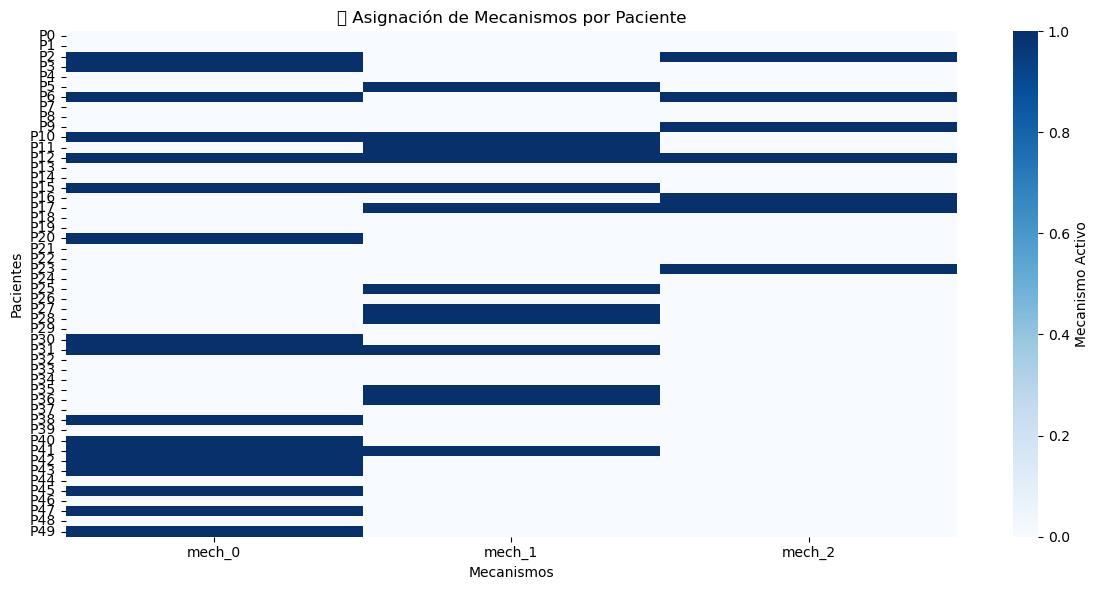

/var/folders/3c/6k7tr9ds3vl83vctg9kzlxdc0000gn/T/ipykernel_51430/1129184354.py:425: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Applications/miniconda3/envs/env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


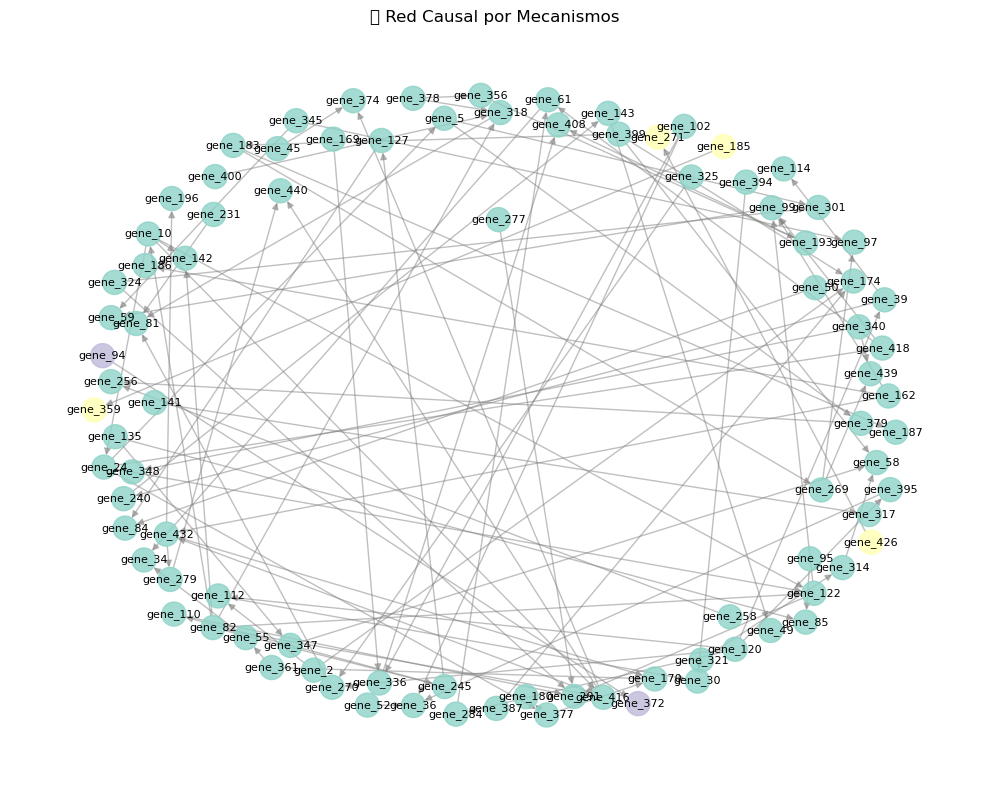

/var/folders/3c/6k7tr9ds3vl83vctg9kzlxdc0000gn/T/ipykernel_51430/1129184354.py:459: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Applications/miniconda3/envs/env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


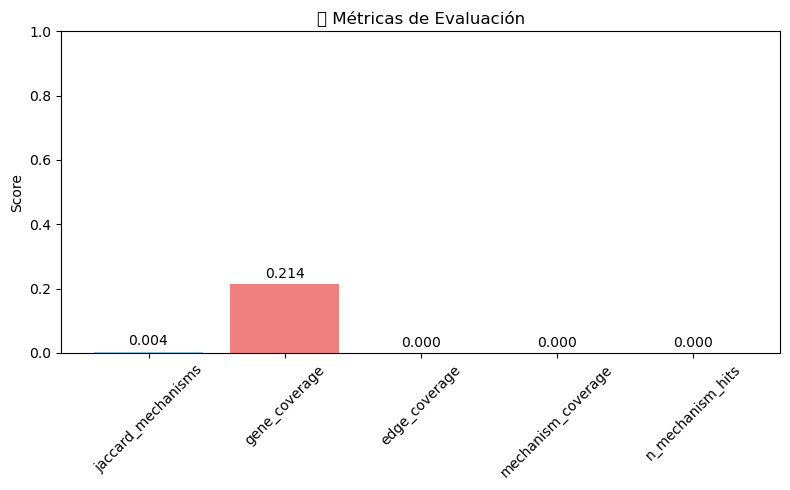


🧩 RESUMEN DE MECANISMOS DESCUBIERTOS:
   mech_0: 84 genes
      Genes: ['gene_356', 'gene_193', 'gene_82', 'gene_10', 'gene_399']...
      Efectos: [-1.0, 1.0, 1.0, -1.0, -1.0]...
   mech_1: 4 genes
      Genes: ['gene_185', 'gene_359', 'gene_426', 'gene_271']
      Efectos: [-1.0, -1.0, -1.0, 1.0]
   mech_2: 2 genes
      Genes: ['gene_94', 'gene_372']
      Efectos: [1.0, 1.0]
Métricas: {'jaccard_mechanisms': 0.003875968992248062, 'ari_assignments': -0.0034733794567750127, 'gene_coverage': 0.21428571428571427, 'edge_coverage': 0.0, 'mechanism_coverage': 0.0, 'n_mechanism_edges': 60, 'n_mechanism_hits': 0, 'n_inferred_edges': 100, 'n_total_mechanism_genes': 14, 'n_discovered_mechanisms': 3, 'n_true_mechanisms': 3}


In [25]:
metrics = evaluate_and_visualize(mechanisms, assignments, graph, M, A, visualize=True)
print("Métricas:", metrics)

In [6]:
# 5. EVALUATION
mechanism_hits, mech_genes = evaluate_against_mechanisms(causal_graph, M)

# Also show which mechanism genes appear in our causal graph
graph_genes = set(causal_graph.nodes())
overlap = graph_genes.intersection({f"gene_{g}" for g in mech_genes})
print(f"\n🧬 Mechanism genes in causal graph: {len(overlap)}/{len(mech_genes)}")

📊 Evaluating causal graph against mechanism structure...
   Total mechanism genes: 14
   Expected within-mechanism pairs: 60
   Inferred edges: 100
   Edges within known mechanisms: 10
   Mechanism coverage: 16.7%

🎯 Sample mechanism-consistent edges:
   gene_89 → gene_464
   gene_10 → gene_25
   gene_89 → gene_133
   gene_89 → gene_156
   gene_445 → gene_200

🧬 Mechanism genes in causal graph: 9/14
